# Import libraries

In [1]:
from semseg_functions import load_imgs_labels,train_model,make_predictions
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# Load Data

In [2]:
urothelial_cells=pd.read_pickle("urothelial_cell_toy_data.pkl")
images=np.transpose(urothelial_cells["X"].numpy()*255,(0,2,3,1)).astype(np.uint8)
labels=urothelial_cells["y"]

X_train,X_val,Y_train,Y_val=train_test_split(images,labels,test_size=0.2,stratify=labels.mean((1,2))>=np.median(labels.mean((1,2))),random_state=42)
X_train,X_val,Y_train,Y_val=torch.FloatTensor(X_train).permute((0,3,1,2)),torch.FloatTensor(X_val).permute((0,3,1,2)),torch.LongTensor(Y_train),torch.LongTensor(Y_val)

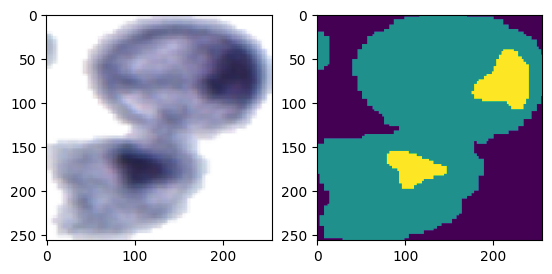

In [3]:
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.subplot(1,2,2)
plt.imshow(labels[0])

# Train model

In [4]:
model=train_model(X_train,Y_train,X_val,Y_val, encoder_name="resnet34", model_key="FPN", n_epochs=25)

Training: Epoch 1, Batch 0, Loss: 1.33
Training: Epoch 1, Batch 1, Loss: 1.043
Training: Epoch 1, Batch 2, Loss: 0.755
Training: Epoch 1, Batch 3, Loss: 0.66
Training: Epoch 1, Batch 4, Loss: 0.599
Training: Epoch 1, Batch 5, Loss: 0.581
Training: Epoch 1, Batch 6, Loss: 0.627
Training: Epoch 1, Batch 7, Loss: 0.58
Training: Epoch 1, Batch 8, Loss: 0.552
Training: Epoch 1, Batch 9, Loss: 0.458
Training: Epoch 1, Batch 10, Loss: 0.524
Training: Epoch 1, Batch 11, Loss: 0.437
Training: Epoch 1, Batch 12, Loss: 0.417
Training: Epoch 1, Batch 13, Loss: 0.511
Training: Epoch 1, Batch 14, Loss: 0.408
Training: Epoch 1, Batch 15, Loss: 0.335
Training: Epoch 1, Batch 16, Loss: 0.557
Training: Epoch 1, Batch 17, Loss: 0.37
Training: Epoch 1, Batch 18, Loss: 0.408
Training: Epoch 1, Batch 19, Loss: 0.342
Val: Epoch 1, Loss: 199.334
Training: Epoch 2, Batch 0, Loss: 0.312
Training: Epoch 2, Batch 1, Loss: 0.39
Training: Epoch 2, Batch 2, Loss: 0.326
Training: Epoch 2, Batch 3, Loss: 0.331
Trainin

# Predict on held out test

In [5]:
y_val_pred=make_predictions(X_val, encoder_name="resnet34", model_key="FPN")#,model=model)#model=None)

In [6]:
y_val_pred_lbls=y_val_pred.argmax(1)

# Report segmentation model performance

In [7]:
from sklearn.metrics import classification_report

In [8]:
print(classification_report(Y_val.numpy().flatten(),y_val_pred_lbls.flatten()))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97    980301
           1       0.90      0.88      0.89   1117270
           2       0.80      0.87      0.83    523869

    accuracy                           0.91   2621440
   macro avg       0.89      0.90      0.90   2621440
weighted avg       0.91      0.91      0.91   2621440



# Compare true and predicted NC ratios

In [9]:
nucleus_pred=(y_val_pred_lbls.reshape(y_val_pred_lbls.shape[0],-1)==2).sum(axis=1)
cytoplasm_pred=(y_val_pred_lbls.reshape(y_val_pred_lbls.shape[0],-1)==1).sum(axis=1)
nc_ratio_pred=nucleus_pred/(nucleus_pred+cytoplasm_pred)

In [10]:
nucleus_true=(Y_val.reshape(Y_val.shape[0],-1)==2).sum(axis=1)
cytoplasm_true=(Y_val.reshape(Y_val.shape[0],-1)==1).sum(axis=1)
nc_ratio_true=nucleus_true/(nucleus_true+cytoplasm_true)

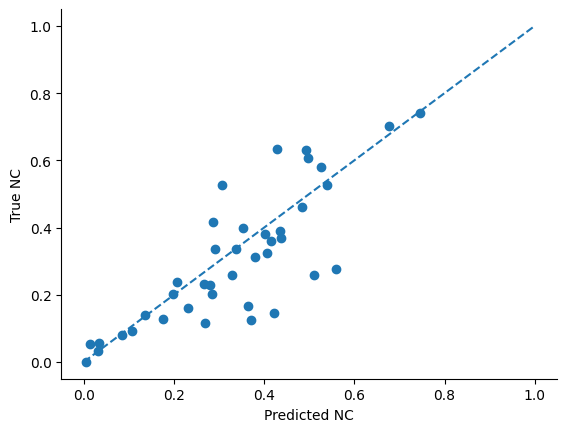

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.scatter(nc_ratio_pred,nc_ratio_true)
plt.plot([0,1],[0,1],ls="--")
plt.xlabel("Predicted NC")
plt.ylabel("True NC")
sns.despine()

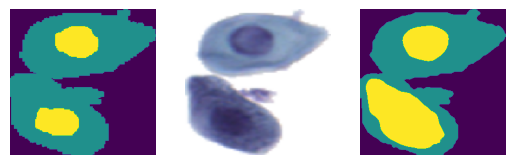

In [15]:
# ! mkdir DL_result_imgs
for idx in range(len(X_val)):
    plt.subplot(131)
    plt.imshow(Y_val[idx])
    plt.axis("off")
    plt.subplot(132)
    plt.imshow((X_val[idx]).permute((1,2,0)).numpy().astype(int))
    plt.axis("off")
    plt.subplot(133)
    plt.imshow(y_val_pred_lbls[idx])
    plt.axis("off")
    plt.savefig(f"DL_result_imgs/urothelial_cell_{idx}.png")

In [13]:
# correlation - true vs predicted
spearmanr(nc_ratio_pred,nc_ratio_true)

SignificanceResult(statistic=0.8058161350844278, pvalue=3.5490748015191814e-10)

In [14]:
# error - true vs predicted
np.abs(nc_ratio_pred-nc_ratio_true.numpy()).mean()

0.08119310800418664